From Samples to Signals: Confidence Intervals, Hypothesis Tests, and Resampling in Python


We will:

Use your de-identified dataset (df_clean)

Treat it as a sample from a larger population

Use Python to make careful, evidence-based claims

In [ ]:
Learning Objectives

By the end of this lecture, you will be able to:

Distinguish between population and sample and explain how sampling bias affects analysis.

Construct and interpret confidence intervals for means and proportions using Python.

Conduct basic hypothesis tests (t-tests, χ² tests) and assess statistical significance from code output.

Use simulation and bootstrapping to visualize uncertainty and variability in estimates.

Apply inferential reasoning to your Case Study 1 dataset to support evidence-based conclusions.

In [3]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 4.5 MB/s eta 0:00:00a 0:00:01


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.proportion import proportion_confint

# Make plots a little nicer
plt.rcParams["figure.figsize"] = (6, 4)

# Load original dataset
df = pd.read_csv("/Users/vanessaklotzman/Desktop/Example-Notes-Comp641/Week2/covid_clinical_notes_synthetic.csv")

df.head()


,patient_id,encounter_id,patient_name,age,sex,city,zip_code,phone_number,admission_date,discharge_date,hospital_name,provider_name,covid_test_result,icu_admission,oxygen_saturation,temperature_c,comorbidities,note_text
0,P0001,E1000,Maria Smith,69,Other,Pasadena,91502,747-555-3286,2020-06-01,2020-06-09,St. Mary's Medical Center,Dr. David Kim,Pending,Yes,89.6,37.9,asthma;copd,Maria Smith (69 y/o other from Pasadena ZIP 91...
1,P0001,E1001,John Smith,41,Male,Burbank,91502,818-555-4257,2020-03-03,2020-03-09,North Hills Clinic,Dr. Michael Brown,Positive,No,94.3,37.5,copd,John Smith (41 y/o male from Burbank ZIP 91502...
2,P0001,E1002,Ahmed Smith,81,Male,Long Beach,90024,310-555-5552,2020-04-29,2020-05-04,Valley General Hospital,Dr. Jason Lee,Negative,Yes,99.8,38.8,asthma;hypertension;none,Ahmed Smith (81 y/o male from Long Beach ZIP 9...
3,P0002,E1003,Sophia Chen,66,Other,Pasadena,91203,626-555-9785,2020-05-30,2020-06-02,St. Mary's Medical Center,Dr. Michael Brown,Positive,No,94.6,37.6,none,Sophia Chen (66 y/o other from Pasadena ZIP 91...
4,P0002,E1004,Grace Chen,20,Other,Burbank,90802,818-555-1750,2020-06-09,2020-06-12,Valley General Hospital,Dr. Sarah Patel,Positive,Yes,91.9,39.1,none,Grace Chen (20 y/o other from Burbank ZIP 9080...


In [6]:
# For this lecture, assume you've already done:
# - Dropped direct identifiers
# - Masked or transformed quasi-identifiers
# - Searched for PII in note_text

df_clean = df.copy()  # In your notebook, this should be the de-identified version

df_clean.head()
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patient_id         300 non-null    object 
 1   encounter_id       300 non-null    object 
 2   patient_name       300 non-null    object 
 3   age                300 non-null    int64  
 4   sex                300 non-null    object 
 5   city               300 non-null    object 
 6   zip_code           300 non-null    int64  
 7   phone_number       300 non-null    object 
 8   admission_date     300 non-null    object 
 9   discharge_date     300 non-null    object 
 10  hospital_name      300 non-null    object 
 11  provider_name      300 non-null    object 
 12  covid_test_result  300 non-null    object 
 13  icu_admission      300 non-null    object 
 14  oxygen_saturation  300 non-null    float64
 15  temperature_c      300 non-null    float64
 16  comorbidities      300 non

Idea:

Population = all similar patients we care about

Sample = the rows in df_clean

We’ll treat df_clean as a sample and simulate other possible samples using code.

In [25]:
len(df_clean)
df_clean["age"].describe()


count    300.000000
mean      52.716667
std       21.796790
min       18.000000
25%       33.000000
50%       53.000000
75%       73.000000
max       89.000000
Name: age, dtype: float64

In [26]:
# Random sample of 100 patients
random_sample = df_clean.sample(n=100, random_state=0)
random_sample['icu_admission_numeric'] = random_sample['icu_admission'].map({'Yes': 1, 'No': 0})



In [29]:

# Biased sample: only older patients
biased_sample = df_clean[df_clean["age"] >= 65].sample(n=100, random_state=0)


In [30]:
biased_sample["age"].mean()

np.float64(77.7)

In [35]:
biased_sample["icu_admission_numeric"] = pd.to_numeric(
    biased_sample["icu_admission"], errors="coerce"
)

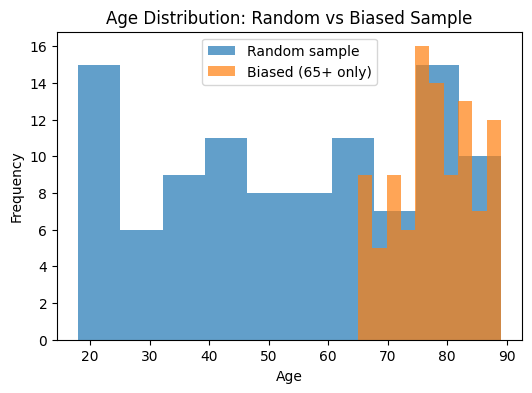

In [36]:
plt.hist(random_sample["age"], alpha=0.7, label="Random sample")
plt.hist(biased_sample["age"], alpha=0.7, label="Biased (65+ only)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution: Random vs Biased Sample")
plt.legend()
plt.show()


In [37]:
ages = df_clean["age"].dropna()

mean_age = ages.mean()
sem_age = stats.sem(ages)  # standard error of the mean

ci_low, ci_high = stats.t.interval(
    confidence=0.95,
    df=len(ages)-1,
    loc=mean_age,
    scale=sem_age
)

print("Sample mean age:", mean_age)
print("95% confidence interval:", (ci_low, ci_high))


Sample mean age: 52.71666666666667
95% confidence interval: (np.float64(50.240148679502305), np.float64(55.19318465383103))


In [47]:
import numpy as np

# Step 1: choose the source column name
icu_col = "icu_admission"  # change this if your actual column name is different

if icu_col not in df_clean.columns:
    raise KeyError(f"Expected ICU column '{icu_col}' not found in df_clean")

# Step 2: build a numeric 0/1 column robustly
# Handles cases like "Yes"/"No", "Y"/"N", 1/0, True/False
icu_raw = df_clean[icu_col]

df_clean["icu_admission_numeric"] = (
    icu_raw
    .astype(str)
    .str.strip()
    .str.lower()
    .map({
        "yes": 1, "y": 1, "true": 1, "1": 1,
        "no": 0, "n": 0, "false": 0, "0": 0
    })
)

# Optional: check mapping results
print(df_clean["icu_admission_numeric"].value_counts(dropna=False))


icu_admission_numeric
1    163
0    137
Name: count, dtype: int64


In [51]:
icu_series = df_clean["icu_admission_numeric"].dropna()
n_total = len(icu_series)
n_icu = icu_series.sum()
n_total = len(icu_series)

prop_icu = n_icu / n_total

ci_low, ci_high = proportion_confint(
    count=n_icu,
    nobs=n_total,
    
    method="wilson"
)

print("Sample ICU proportion:", prop_icu)
print("95% CI for ICU proportion:", (ci_low, ci_high))

Sample ICU proportion: 0.5433333333333333
95% CI for ICU proportion: (0.4867738450556563, 0.5987970974382163)


Question:
Are ICU patients older on average than non-ICU patients?

In [42]:
icu_ages = df_clean[df_clean["icu_admission_numeric"] == 1]["age"].dropna()
non_icu_ages = df_clean[df_clean["icu_admission_numeric"] == 0]["age"].dropna()

stats.ttest_ind(icu_ages, non_icu_ages, equal_var=False)

TtestResult(statistic=np.float64(1.1421143571047088), pvalue=np.float64(0.2543606733448622), df=np.float64(286.32672522889686))

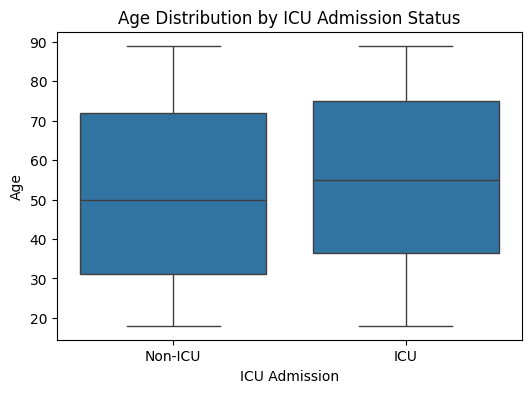

In [53]:
sns.boxplot(x="icu_admission_numeric", y="age", data=df_clean)
plt.xticks([0, 1], ["Non-ICU", "ICU"])
plt.title("Age Distribution by ICU Admission Status")
plt.xlabel("ICU Admission")
plt.ylabel("Age")
plt.show()


In [54]:
contingency = pd.crosstab(
    df_clean["icu_admission_numeric"],
    df_clean["covid_test_result"]
)
print(contingency)

chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Expected counts:\n", expected)


covid_test_result      Negative  Pending  Positive
icu_admission_numeric                             
0                            40       53        44
1                            57       51        55
Chi-square statistic: 2.0017673677672936
p-value: 0.36755449563386716
Expected counts:
 [[44.29666667 47.49333333 45.21      ]
 [52.70333333 56.50666667 53.79      ]]


Question:
If we repeatedly drew samples of 50 patients, how much would the average age vary?

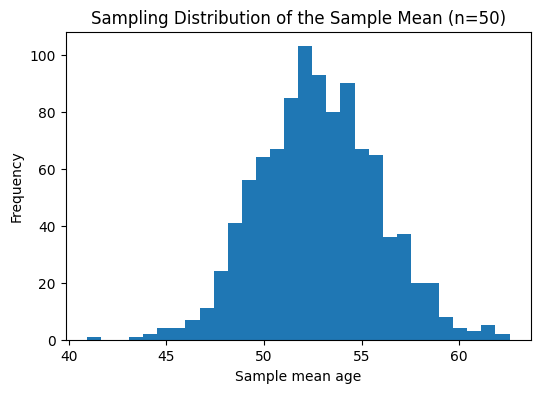

In [45]:
sample_means = []

for i in range(1000):
    sample = df_clean["age"].dropna().sample(n=50, replace=True)
    sample_means.append(sample.mean())

plt.hist(sample_means, bins=30)
plt.title("Sampling Distribution of the Sample Mean (n=50)")
plt.xlabel("Sample mean age")
plt.ylabel("Frequency")
plt.show()


Bootstrap mean age CI: (np.float64(50.29316666666667), np.float64(55.17691666666666))


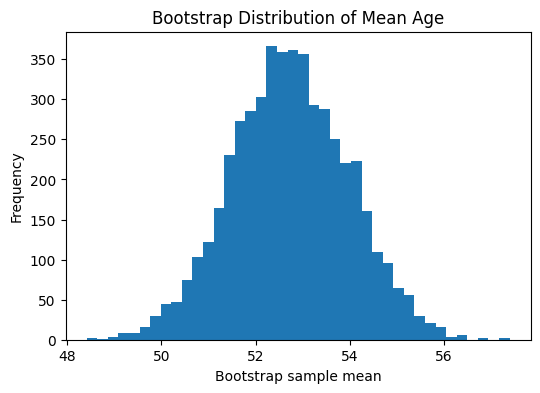

In [55]:
ages = df_clean["age"].dropna().values

boot_means = []
n_bootstraps = 5000

for _ in range(n_bootstraps):
    boot_sample = np.random.choice(ages, size=len(ages), replace=True)
    boot_means.append(boot_sample.mean())

ci_low, ci_high = np.percentile(boot_means, [2.5, 97.5])

print("Bootstrap mean age CI:", (ci_low, ci_high))

plt.hist(boot_means, bins=40)
plt.title("Bootstrap Distribution of Mean Age")
plt.xlabel("Bootstrap sample mean")
plt.ylabel("Frequency")
plt.show()


In [ ]:
icu_array = df_clean["icu_admit_numeric"].dropna().values

boot_props = []
for _ in range(5000):
    boot_sample = np.random.choice(icu_array, size=len(icu_array), replace=True)
    boot_props.append(boot_sample.mean())

ci_low, ci_high = np.percentile(boot_props, [2.5, 97.5])

print("Bootstrap ICU proportion CI:", (ci_low, ci_high))

plt.hist(boot_props, bins=40)
plt.title("Bootstrap Distribution of ICU Proportion")
plt.xlabel("Bootstrap ICU proportion")
plt.ylabel("Frequency")
plt.show()


For your Case Study 1 notebook, you can:

Describe the sample:

Use df_clean.describe() and value_counts()

Check for sampling bias:

Compare different sub-samples if relevant

Estimate key quantities with intervals:

Confidence intervals for age, ICU proportion, etc.

Test simple hypotheses:

t-tests for group differences

chi-square tests for categorical relationships

Use bootstrapping:

Show uncertainty visually

Write cautious conclusions:

Always relate back to real patients and real-world decisions